<a href="https://colab.research.google.com/github/garrisonz/reproduce/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l
!pip install ipython-autotime
%load_ext autotime

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

time: 920 ms (started: 2022-06-22 09:26:45 +00:00)


In [3]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

time: 3.28 ms (started: 2022-06-22 09:26:46 +00:00)


In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

time: 999 µs (started: 2022-06-22 09:26:46 +00:00)


In [5]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

time: 1.15 s (started: 2022-06-22 09:26:46 +00:00)


In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
time: 336 ms (started: 2022-06-22 09:26:47 +00:00)


In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]

time: 6.47 ms (started: 2022-06-22 09:26:47 +00:00)


In [8]:
net = vgg(small_conv_arch)

time: 445 ms (started: 2022-06-22 09:26:47 +00:00)


In [9]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 16, 112, 112])
Sequential output shape:	 torch.Size([1, 32, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 28, 28])
Sequential output shape:	 torch.Size([1, 128, 14, 14])
Sequential output shape:	 torch.Size([1, 128, 7, 7])
Flatten output shape:	 torch.Size([1, 6272])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
time: 84.1 ms (started: 2022-06-22 09:26:48 +00:00)


loss 0.175, train acc 0.935, test acc 0.914
751.1 examples/sec on cuda:0


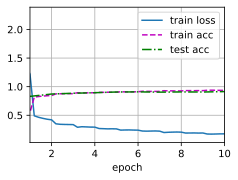

time: 14min 48s (started: 2022-06-22 09:26:48 +00:00)


In [10]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())